In [1]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision import transforms, datasets, models
import torch.nn.init as init
from torch.optim.lr_scheduler import StepLR


We always check that we are running on a GPU

In [2]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


We provide you with a class that can load the *hotdog/not hotdog* dataset you should use from /dtu/datasets1/02516/

In [3]:
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='/dtu/datasets1/02516/hotdog_nothotdog'):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        
        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y

Below is the simple way of converting the images to something that can be fed through a network.
Feel free to use something other than $128\times128$ images.

In [4]:

# Define the size and rotation degrees
size = 128
rotation_degrees = 90  # Adjust as needed

# Modify the train_transform to include random rotations
train_transform = transforms.Compose([
    transforms.RandomRotation(degrees=(-rotation_degrees, rotation_degrees)),
    transforms.Resize((size, size)),
    transforms.ToTensor(),
])

# Keep the test_transform as it is
test_transform = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
])

# Rest of your code remains unchanged
batch_size = 64
trainset = Hotdog_NotHotdog(train=True, transform=train_transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
testset = Hotdog_NotHotdog(train=False, transform=test_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)

Let's look at some images from our data 

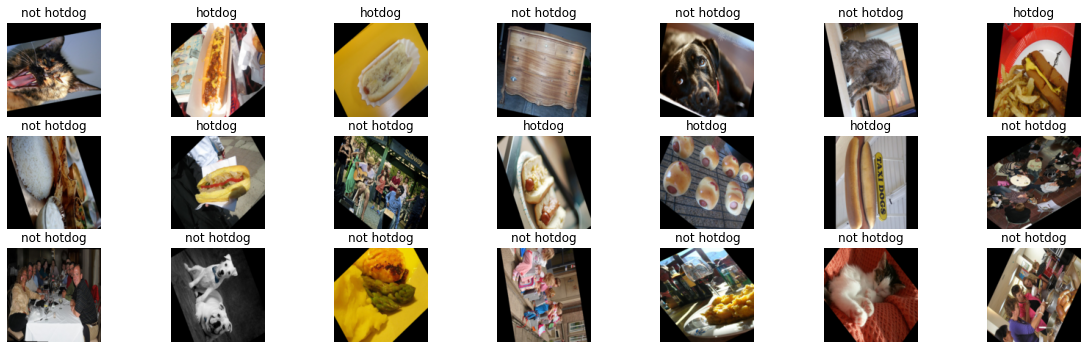

In [5]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title(['hotdog', 'not hotdog'][labels[i].item()])
    plt.axis('off')


Remember to save the state of your model AND optimizer regularly in case the Colab runtime times out.
You can save your model to your google drive, so you can get it from there in a new colab session. 

If you only save it in the colab notebook, there's no way to get it into a new session.

In [6]:
# Instantiate the VGG11 model with or without pretrained weights
model = models.vgg11(pretrained=True)

# Modify the classifier for your specific task
# Example: Replace the final fully connected layer for binary classification
model.classifier[6] = nn.Sequential(
    nn.Linear(4096, 1024),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),  # Add a dropout layer with dropout probability of 0.5
    nn.Linear(1024, 2)  # Change 2 to the number of classes in your dataset
)

# Set device and define loss function and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

Now create a model and train it!


In [ ]:
# Initialize the weights of the linear layers for the model without pretained weights

for layer in model.classifier.children():
    if isinstance(layer, nn.Linear):
        init.xavier_uniform_(layer.weight)
        
for layer in model.classifier.children():
    if isinstance(layer, nn.Conv2d):
        init.xavier_uniform_(layer.weight)

In [7]:

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = StepLR(optimizer, step_size=4, gamma=0.1)  # Adjust step_size and gamma as needed

In [8]:
num_epochs = 10

for epoch in tqdm(range(num_epochs), unit='epoch'):
    # For each epoch
    model.train()
    train_correct = 0

    for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        data, target = data.to(device), target.to(device)

        # Zero the gradients computed for each weight
        optimizer.zero_grad()
        
        # Forward pass your image through the network
        output = model(data)
        
        # Compute the loss
        loss = criterion(output, target)
        
        # Backward pass through the network
        loss.backward()
        
        # Update the weights
        optimizer.step()

        # Compute how many were correctly classified
        predicted = output.argmax(1)
        train_correct += (target == predicted).sum().cpu().item()
        
    scheduler.step()  # Update the learning rate at the end of each epoch
    # Compute the test accuracy
    model.eval()
    test_correct = 0

    for data, target in test_loader:
        data, target = data.to(device), target.to(device)

        with torch.no_grad():
            output = model(data)

        predicted = output.argmax(1)  # Keep predicted on the GPU
        target = target.to(device)  # Ensure target is on the GPU

        test_correct += (target == predicted).sum().item()        

    train_acc = train_correct / len(trainset)
    test_acc = test_correct / len(testset)
    print("Accuracy train: {train:.1f}%\t test: {test:.1f}%".format(test=100 * test_acc, train=100 * train_acc))

  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Accuracy train: 81.9%	 test: 89.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Accuracy train: 88.9%	 test: 92.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Accuracy train: 92.0%	 test: 91.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Accuracy train: 94.2%	 test: 91.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Accuracy train: 95.8%	 test: 92.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Accuracy train: 96.7%	 test: 92.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Accuracy train: 97.4%	 test: 92.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Accuracy train: 97.6%	 test: 92.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Accuracy train: 97.8%	 test: 92.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Accuracy train: 97.5%	 test: 92.8%
